In [1]:
import os
import numpy as np
from scipy.io import loadmat
import random

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'
plt_save_path = '../result/WSHR/figures'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [16]:
# give the preset classification of determined variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "ABRK", "NSQT",
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", "TH", 
                       "TAS", "CASM", "GS",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = [
                   "FADS", 
                   
                   "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL",
                   "LGDN"]
var_group_control = ["HDGS", "PTRM", 
                     "RUDP", "CCPC", "CCPF", "CWPC", "CWPF",
                     "SNAP", 
                     "GPWS", "SHKR", "FADF"]
var_group_external = ["ALT", "WS", "WD", "PT", "TAT",
                      "LOC"]
var_group_recorder = ["PH"
                     ]
var_group_unclassified = ["EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "SMKB"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

mechanism: 25
power: 11
control: 11
external: 6
recorder: 1
unclassified: 7

61 variables in total


In [8]:
'''
检查所有预选变量在原始数据中的完整性，筛选出能保证全变量完整的子数据集作为MLP的训练集和测试集；
以训练的MLP对原始数据进行数据补正，以供之后通过随机森林在WSHR的二分类问题上对特征变量进行再次评估，以迭代出新的预选变量集
'''

# 检查预选变量数据完整性并生成工作子集
def check_var_integrity(mat, download_folder_path, mat_name):
    for group_name, var_group in var_groups_dict.items():
        for var_name in var_group:
            if np.mean(mat[var_name][0][0][0]) == 0 and np.var(mat[var_name][0][0][0]) == 0:
                # print(f"{var_name} in {group_name} is empty")
                # print(f"Jump mat {mat_name}")
                return False
    print(f"Receive mat {download_folder_path}: {mat_name}")
    return True

work_dict = {}
# for exception_folder_path in exception_folder_paths:
#     for exception_mat_name in os.listdir(exception_folder_path):
#         e_mat = loadmat(os.path.join(exception_folder_path, exception_mat_name))
#         if check_var_integrity(e_mat, exception_mat_name):
#             work_dict[exception_mat_name] = e_mat
'''
Received matname: []
'''

for download_folder_path in download_folder_paths:
    for download_mat_name in os.listdir(download_folder_path):
        d_mat = loadmat(os.path.join(download_folder_path, download_mat_name))
        if check_var_integrity(d_mat, download_folder_path, download_mat_name):
            work_dict[download_mat_name] = d_mat
'''
Received matname: ['653200212291431.mat', '660200210081101.mat','686200105101854.mat']
'''

np.save("../result/variable_evaluate/work_dict.npy", work_dict)

Receive mat 653200212291431.mat
Receive mat 660200210081101.mat
Receive mat 686200105101854.mat


In [14]:
# 统计存在数据缺失的所有变量，设置为待补完变量
invalid_var_dict = {}
for group_name, var_group in var_groups_dict.items():
    invalid_var_list = []
    for var_name in var_group:
        print(f"Checking {var_name} in {group_name} ...")
        break_flag = False
        # for download_folder_path in download_folder_paths:
        #     print(f"Arrive at folder {download_folder_path.split('/')[-1]}")
        #     for download_mat_name in os.listdir(download_folder_path):
        #         d_mat = loadmat(os.path.join(download_folder_path, download_mat_name))
        #         if np.mean(d_mat[var_name][0][0][0]) == 0 and np.var(d_mat[var_name][0][0][0]) == 0:
        #             invalid_var_list.append(var_name)
        #             print(f"----- {var_name} in {group_name} is invalid -----")
        #             break_flag = True
        #             break
        #     if break_flag:
        #         break
        for exception_folder_path in exception_folder_paths:
            # print(f"Arrive at folder {exception_folder_path.split('/')[-1]}")
            for exception_mat_name in os.listdir(exception_folder_path):
                e_mat = loadmat(os.path.join(exception_folder_path, exception_mat_name))
                if np.mean(e_mat[var_name][0][0][0]) == 0 and np.var(e_mat[var_name][0][0][0]) == 0:
                    invalid_var_list.append(var_name)
                    print(f"----- {var_name} in {group_name} is invalid -----")
                    break_flag = True
                    break
            if break_flag:
                break
    invalid_var_dict[group_name] = invalid_var_list

Checking AIL_1 in mechanism ...
Checking AIL_2 in mechanism ...
Checking FLAP in mechanism ...
----- FLAP in mechanism is invalid -----
Checking ELEV_1 in mechanism ...
Checking ELEV_2 in mechanism ...
Checking RUDD in mechanism ...
Checking SPL_1 in mechanism ...
Checking SPL_2 in mechanism ...
Checking SPLG in mechanism ...
----- SPLG in mechanism is invalid -----
Checking ABRK in mechanism ...
Checking NSQT in mechanism ...
----- NSQT in mechanism is invalid -----
Checking AOA1 in mechanism ...
----- AOA1 in mechanism is invalid -----
Checking AOA2 in mechanism ...
----- AOA2 in mechanism is invalid -----
Checking GLS in mechanism ...
----- GLS in mechanism is invalid -----
Checking PTCH in mechanism ...
----- PTCH in mechanism is invalid -----
Checking ROLL in mechanism ...
----- ROLL in mechanism is invalid -----
Checking TH in mechanism ...
----- TH in mechanism is invalid -----
Checking TAS in mechanism ...
----- TAS in mechanism is invalid -----
Checking CASM in mechanism ...
-

In [15]:
invalid_var_dict = {'mechanism': ['FLAP', 'SPLG', 'NSQT', 'AOA1', 'AOA2', 'GLS', 'PTCH', 'ROLL', 'TH', 'TAS', 'CASM', 'GS', 'FPAC', 'CTAC'], \
                    'power': ['FADS', 'FQTY_1', 'FQTY_2', 'FQTY_3', 'FQTY_4', 'OIPL', 'LGDN'], \
                        'control': ['HDGS', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF', 'SNAP', 'SHKR', 'FADF'], \
                            'external': ['ALT', 'WS', 'WD', 'PT', 'TAT', 'LOC'], 'recorder': ['PH'], \
                                'unclassified': ['EVNT', 'HF1', 'HF2', 'VHF1', 'VHF2', 'VHF3', 'SMKB']}
invalid_group_lens_dict = {}
for group_name, var_group in invalid_var_dict.items():
    invalid_group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(invalid_group_lens_dict.values())} invalid variables in total\n")

valid_var_dict = {group_name: list(set(var_groups_dict[group_name]) - set(invalid_var_dict[group_name])) for group_name in var_groups_dict.keys()}
valid_group_lens_dict = {}
for group_name, var_group in valid_var_dict.items():
    valid_group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(valid_group_lens_dict.values())} valid variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx):
    count = 0
    for group_name, var_group in invalid_var_dict.items():
        if count + invalid_group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += invalid_group_lens_dict[group_name]

mechanism: 14
power: 7
control: 9
external: 6
recorder: 1
unclassified: 7

44 invalid variables in total

mechanism: 11
power: 4
control: 2
external: 0
recorder: 0
unclassified: 0

17 valid variables in total


In [4]:
# 构建训练集和测试集
def minMaxNormalization(data):
    Min = np.min(data, axis=0)
    Max = np.max(data, axis=0)
    Mean = np.mean(data, axis=0)
    Std = np.std(data, axis=0)
    if (Std != 0).all():
        data = (data - Min) / (Max - Min)
    return data

def datasetConstruction(mat):
    X_array, Y_array = [], []
    response_wshr_array = mat["WSHR"][0][0][0]
    # 依据WSHR变量对各变量进行过采样或下采样，以实现张量化
    for group_name, var_list in var_groups_dict.items():
        for var_name in var_list:
            # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            if var_rate == 1:
                X_array.append(var_data[:-1])
                if var_name in invalid_var_dict[group_name]:
                    Y_array.append(var_data[1:])
            elif var_rate > 1: # 进行下采样
                # print(len(var_data.tolist()))
                sampling_data = random.sample(var_data.tolist(), k=len(response_wshr_array))
                X_array.append(sampling_data[:-1])
                if var_name in invalid_var_dict[group_name]:
                    Y_array.append(sampling_data[1:])
            else:
                sampling_data = random.choices(var_data, k=len(response_wshr_array))
                X_array.append(sampling_data[:-1])
                if var_name in invalid_var_dict[group_name]:
                    Y_array.append(sampling_data[1:])
    X_array = np.squeeze(np.array(X_array)).T
    Y_array = np.squeeze(np.array(Y_array)).T
    # Y_array = np.array(response_wshr_array[:-1])
    # Y_array = Y_array[:,0:1]

    # # 对解释变量和响应变量进行max-min正则化
    # X_array = minMaxNormalization(X_array)
    # Y_array = minMaxNormalization(Y_array)

    return [X_array, Y_array]

complete_mat_list = ['Tail_653_5/653200212291431.mat', 'Tail_660_5/660200210081101.mat','Tail_686_1/686200105101854.mat']

train_X, train_Y = [np.concatenate((datasetConstruction(loadmat(os.path.join(download_save_path, complete_mat_list[0])))[i], \
                                  datasetConstruction(loadmat(os.path.join(download_save_path, complete_mat_list[1])))[i]), axis=0) for i in range(2)]
print(train_X.shape, train_Y.shape)

test_X, test_Y = datasetConstruction(loadmat(os.path.join(download_save_path, complete_mat_list[2])))
print(test_X.shape, test_Y.shape)

(11506, 61) (11506, 44)
(7251, 61) (7251, 44)


===== Checking mechanism: FLAP =====
train complete
test complete
evaluate complete
模型性能： 0.9949301373353087


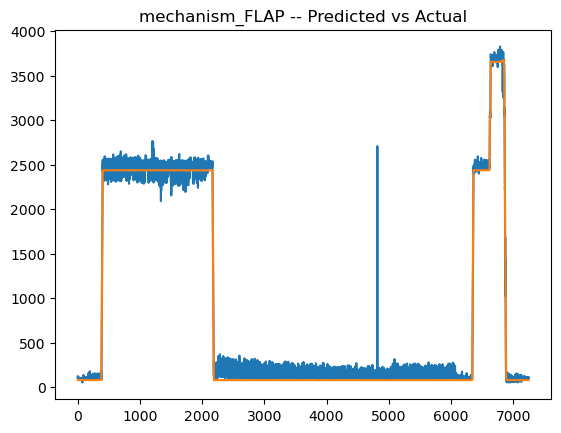

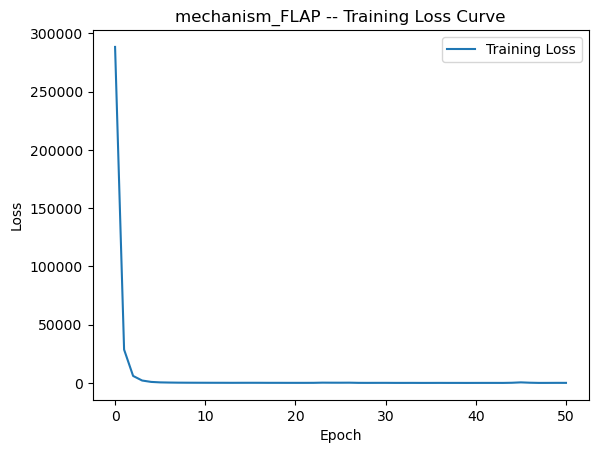

===== Checking mechanism: SPLG =====
train complete
test complete
evaluate complete
模型性能： -21.325026382860763


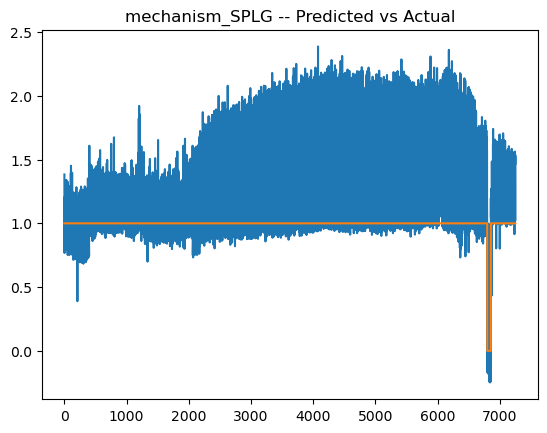

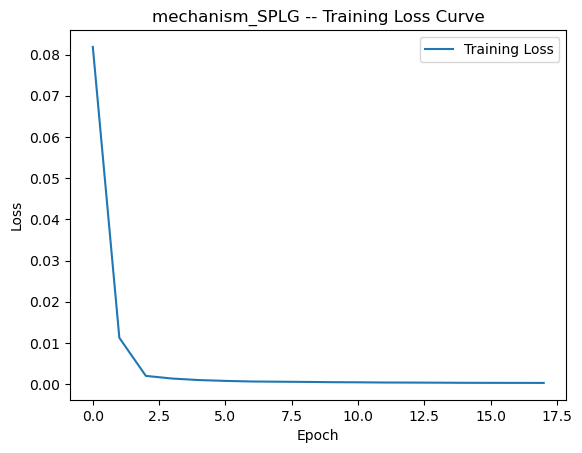

===== Checking mechanism: NSQT =====
train complete
test complete
evaluate complete
模型性能： -2.1319433816666162


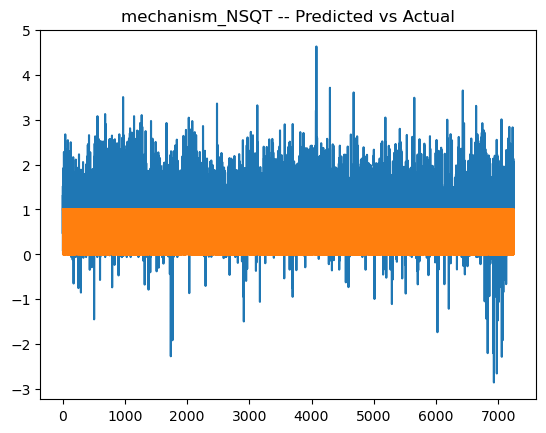

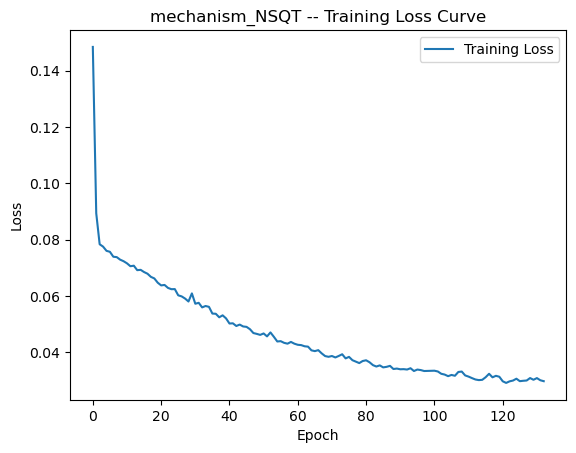

===== Checking mechanism: AOA1 =====
train complete
test complete
evaluate complete
模型性能： -7.9343361671364985


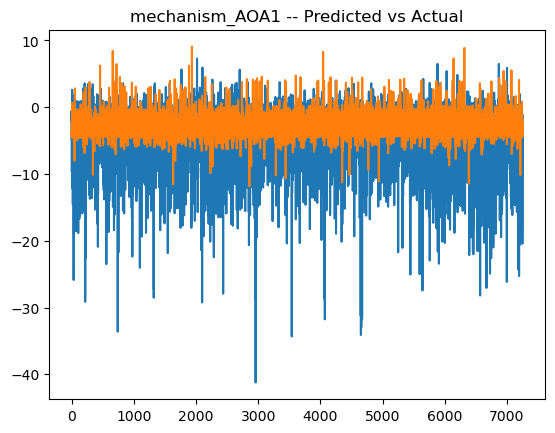

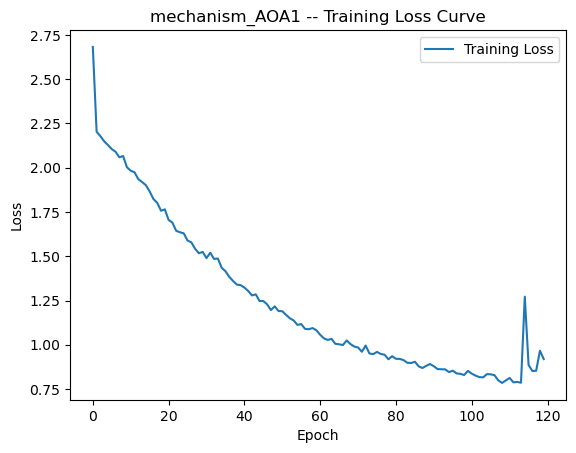

===== Checking mechanism: AOA2 =====
train complete
test complete
evaluate complete
模型性能： -2.673953394445618


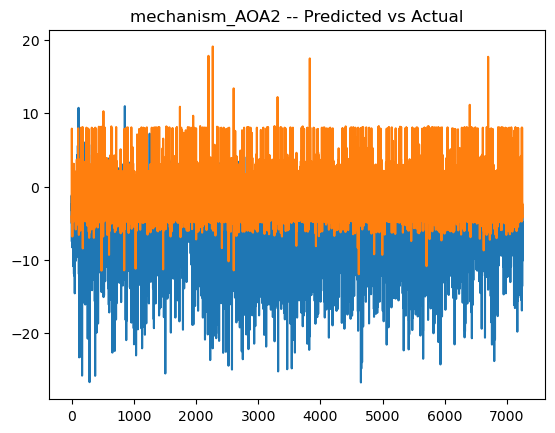

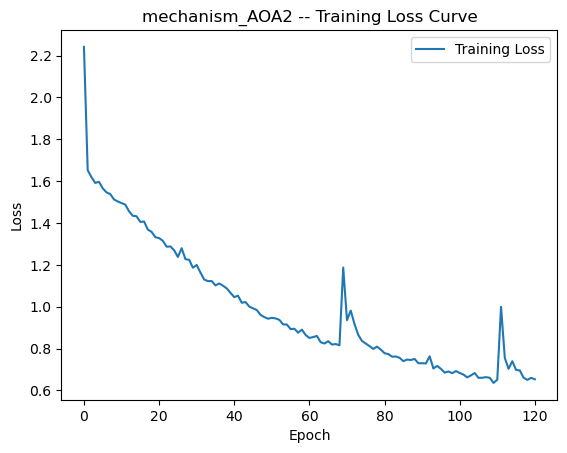

===== Checking mechanism: GLS =====
train complete
test complete
evaluate complete
模型性能： -0.25524643330120034


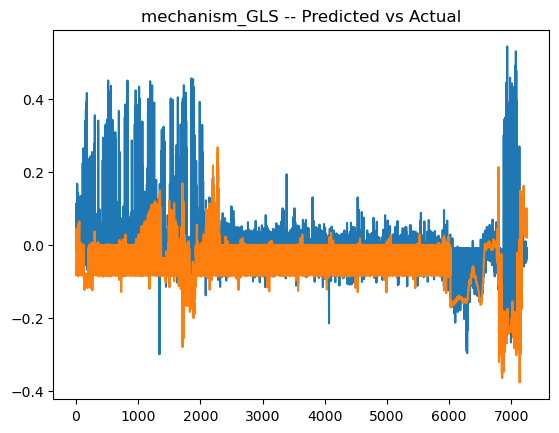

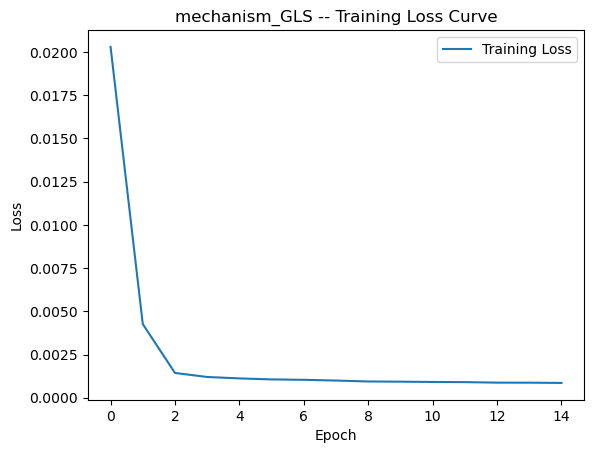

===== Checking mechanism: PTCH =====
train complete
test complete
evaluate complete
模型性能： -2.2388748113782615


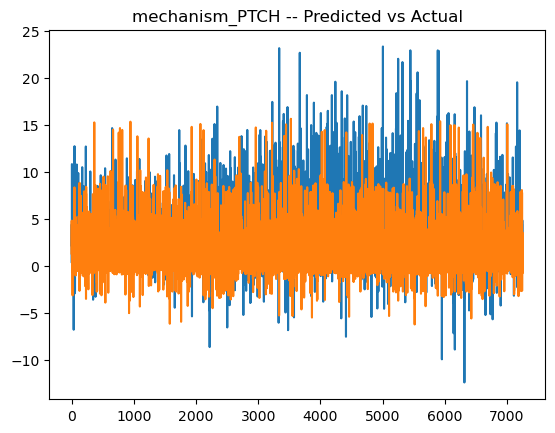

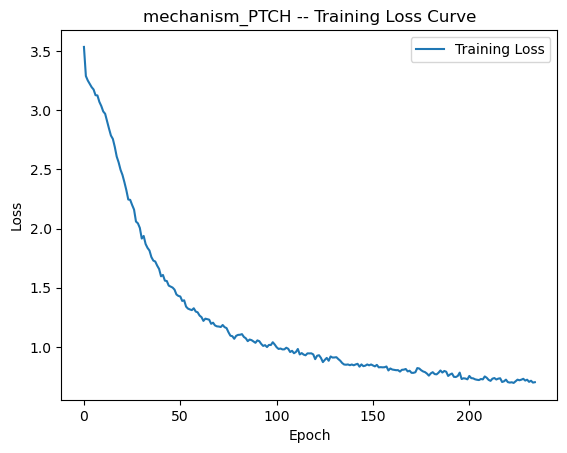

===== Checking mechanism: ROLL =====
train complete
test complete
evaluate complete
模型性能： -1.154309068575809


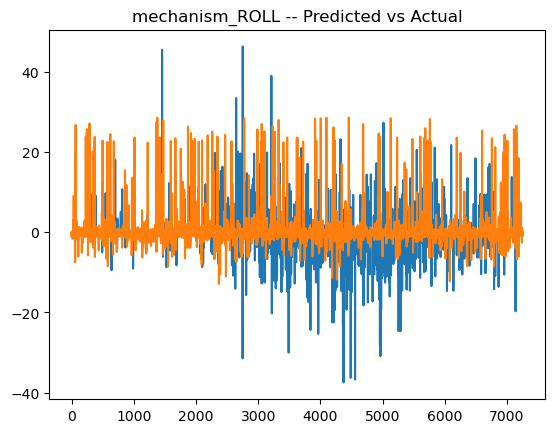

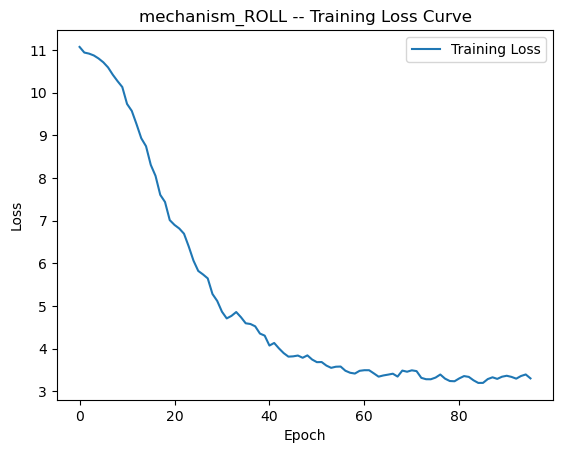

===== Checking mechanism: TH =====
train complete
test complete
evaluate complete
模型性能： -2.9382458450125366


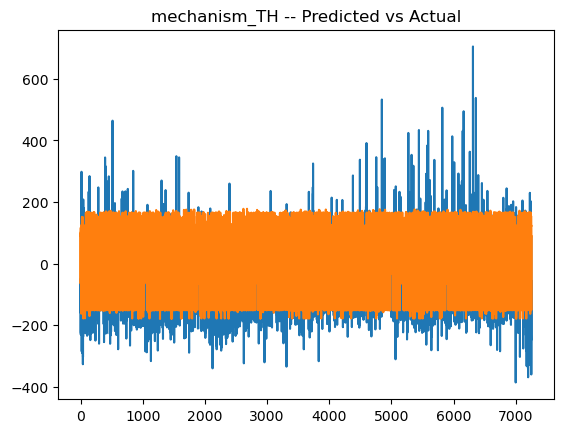

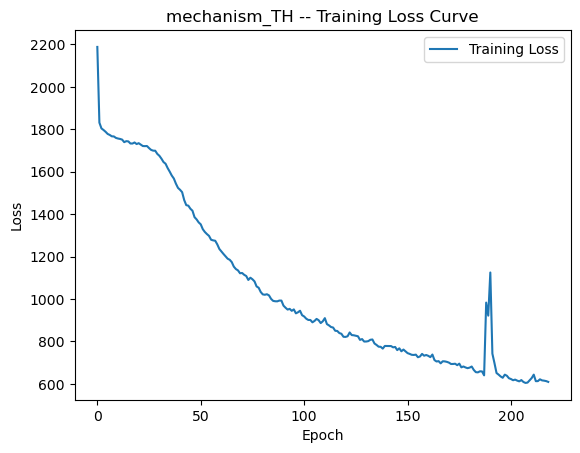

===== Checking mechanism: TAS =====
train complete
test complete
evaluate complete
模型性能： -6.907337793153041


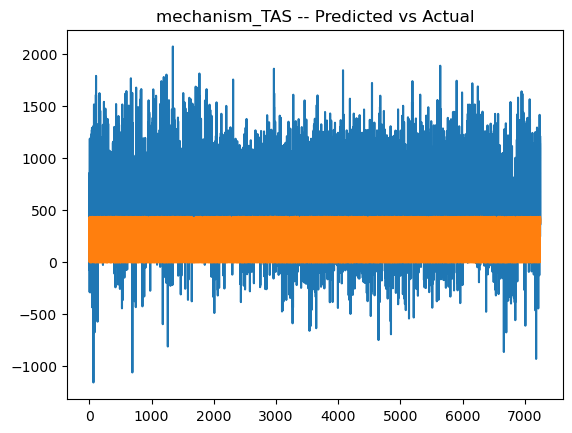

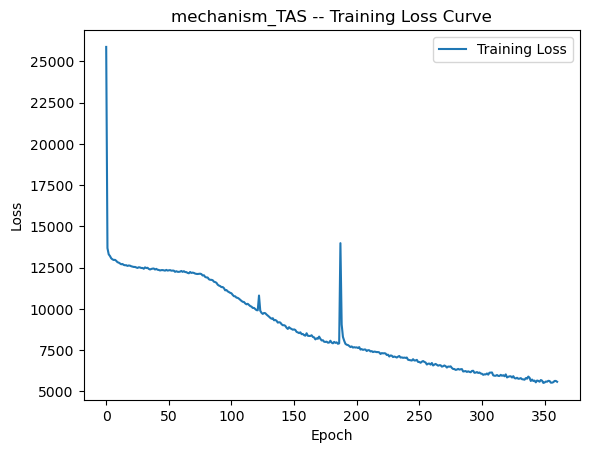

===== Checking mechanism: CASM =====
train complete
test complete
evaluate complete
模型性能： -1091.616524112485


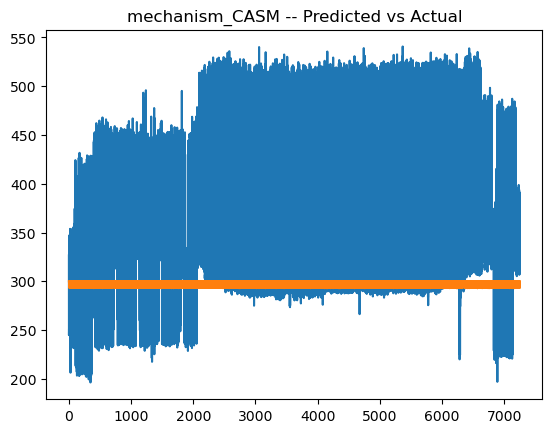

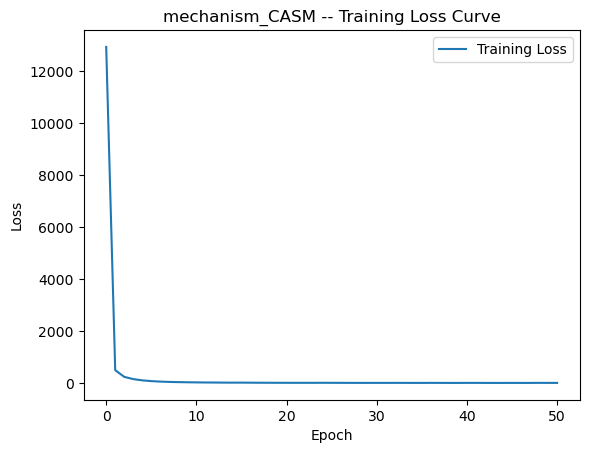

===== Checking mechanism: GS =====
train complete
test complete
evaluate complete
模型性能： -14.107315839340552


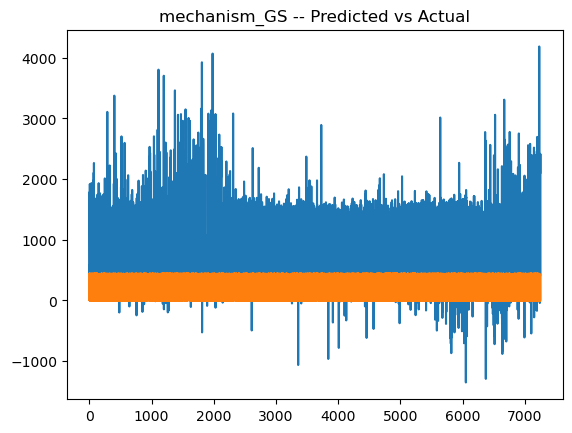

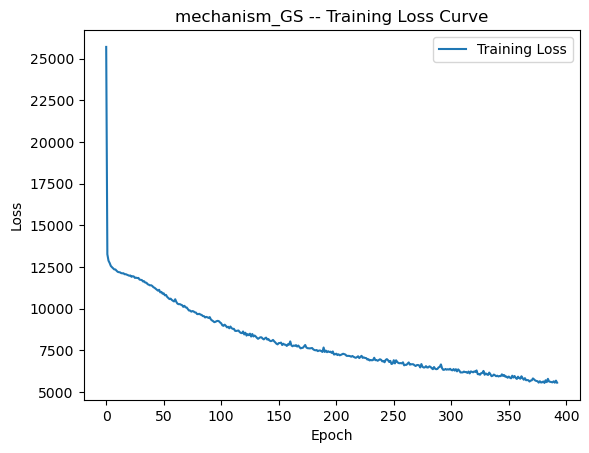

===== Checking mechanism: FPAC =====
train complete
test complete
evaluate complete
模型性能： -3.065905319182482


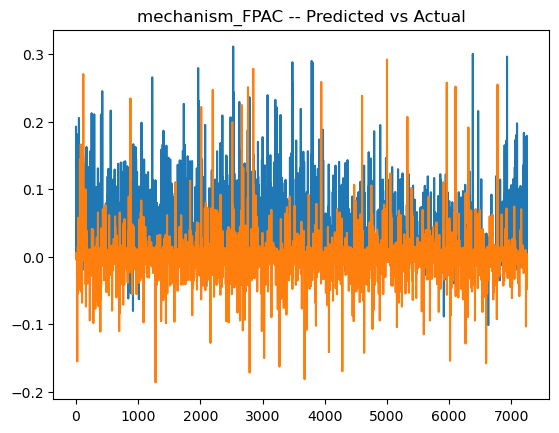

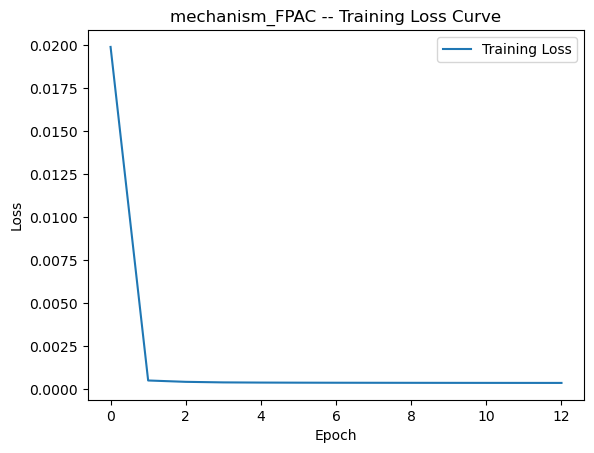

===== Checking mechanism: CTAC =====
train complete
test complete
evaluate complete
模型性能： -0.34215374453915026


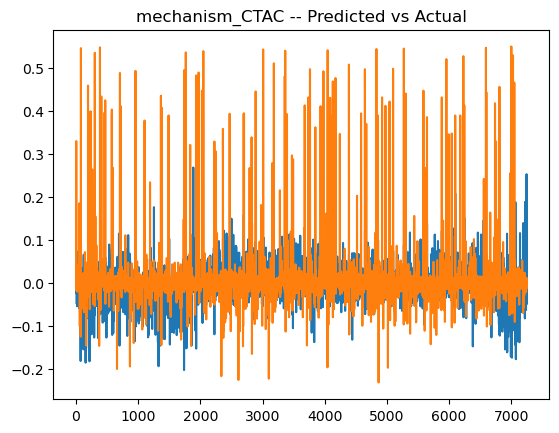

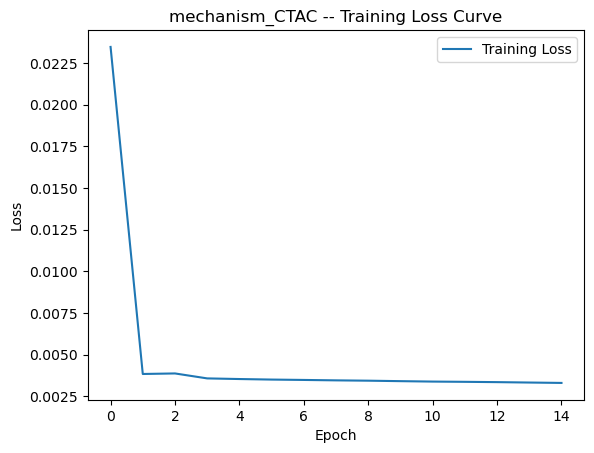

===== Checking power: FADS =====
train complete
test complete
evaluate complete
模型性能： 0.0


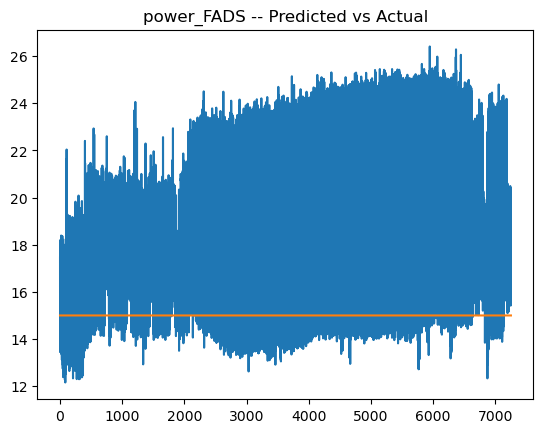

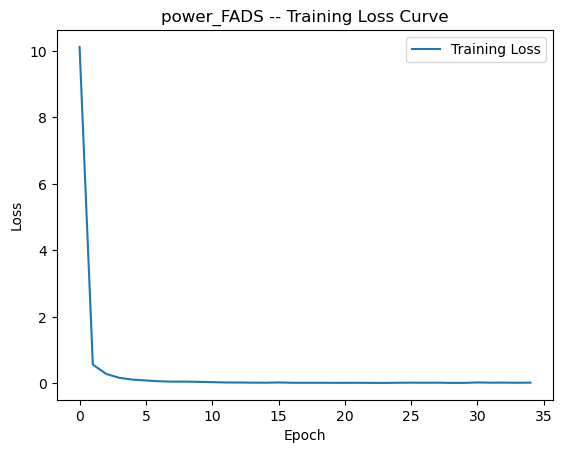

===== Checking power: FQTY_1 =====
train complete
test complete
evaluate complete
模型性能： -5.0769482873299285


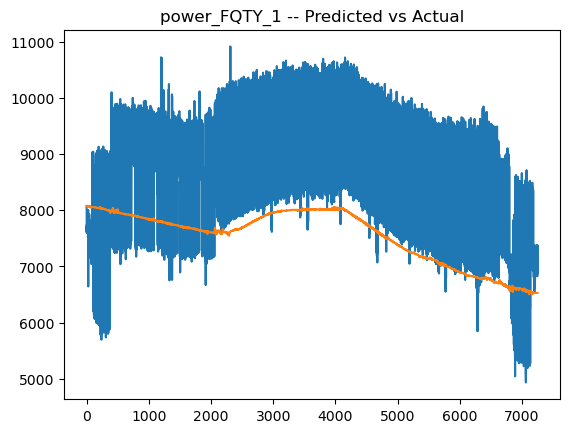

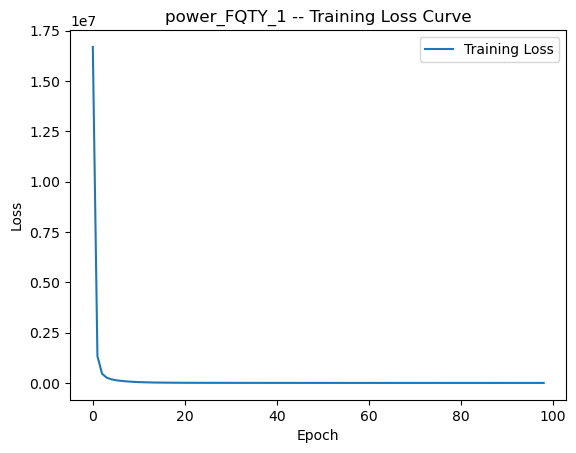

===== Checking power: FQTY_2 =====
train complete
test complete
evaluate complete
模型性能： 0.9333012523506619


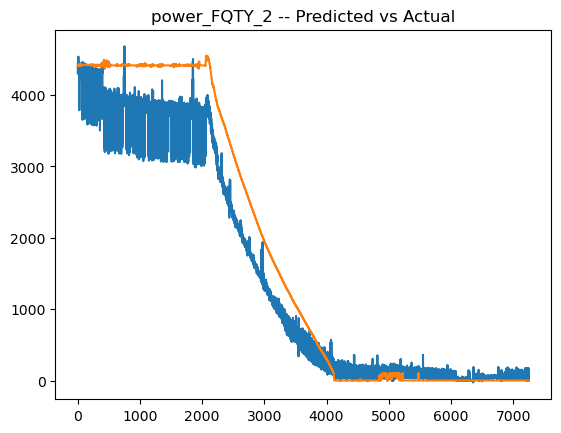

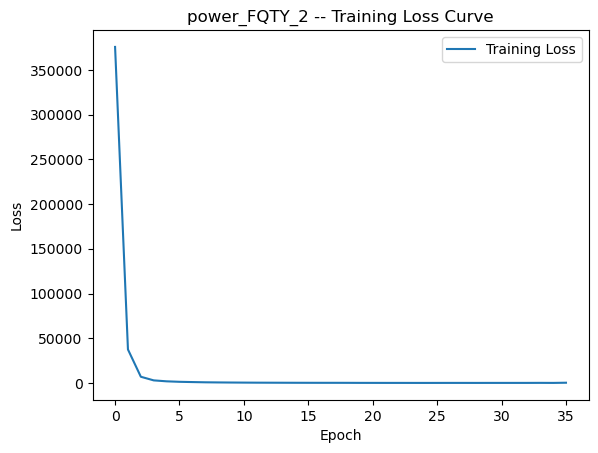

===== Checking power: FQTY_3 =====
train complete
test complete
evaluate complete
模型性能： -0.00014657142608154317


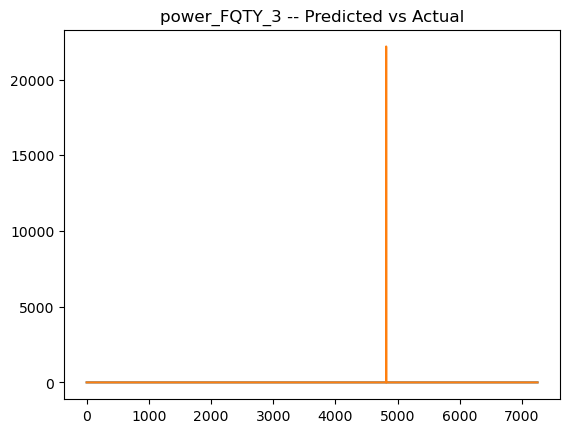

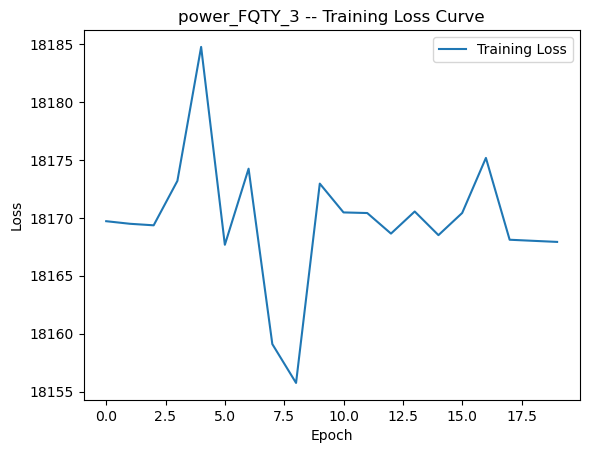

===== Checking power: FQTY_4 =====
train complete
test complete
evaluate complete
模型性能： -2.49001664248276


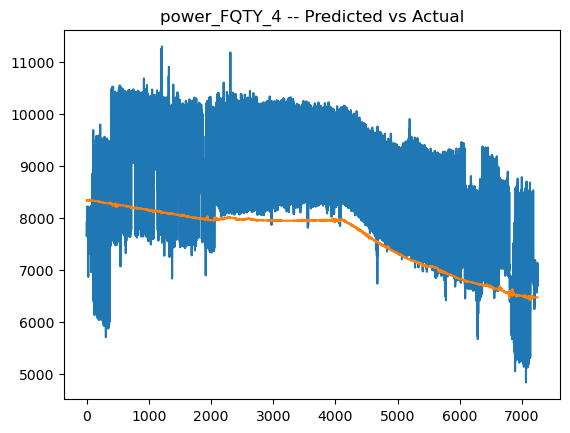

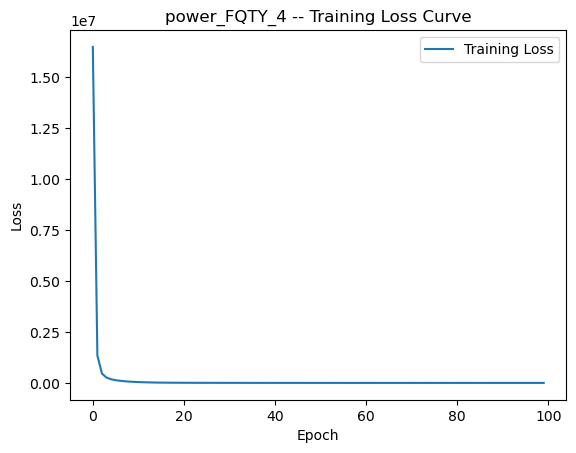

===== Checking power: OIPL =====
train complete
test complete
evaluate complete
模型性能： -3.637464124768818


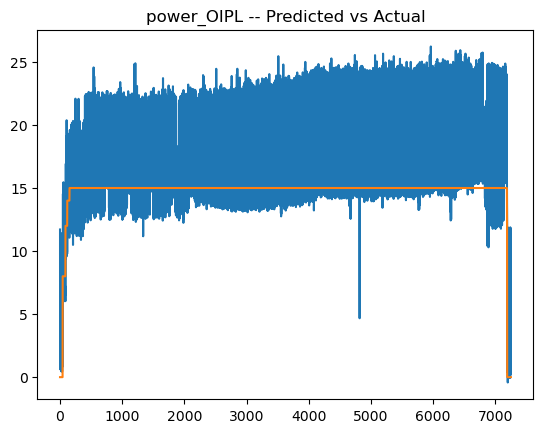

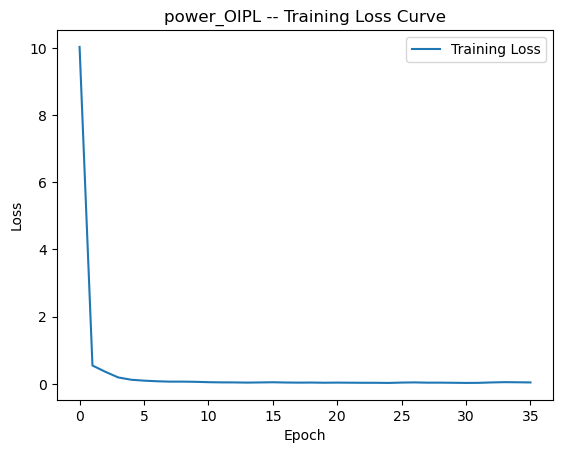

===== Checking power: LGDN =====
train complete
test complete
evaluate complete
模型性能： -0.08748716627119357


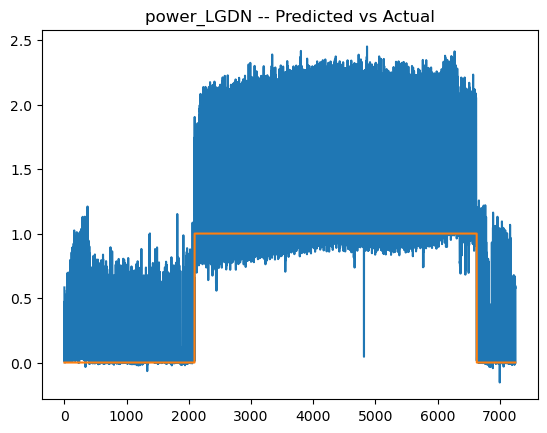

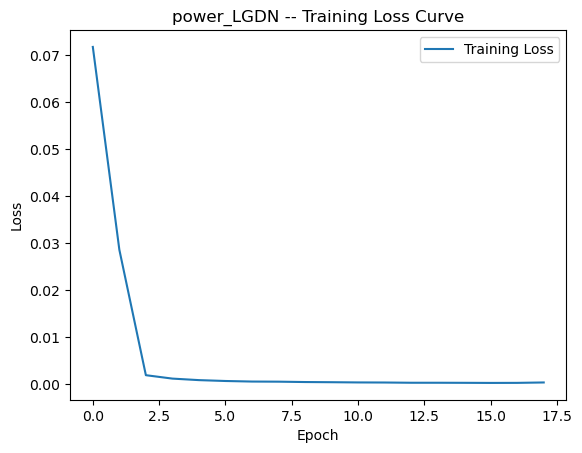

===== Checking control: HDGS =====
train complete
test complete
evaluate complete
模型性能： 0.5665781585107176


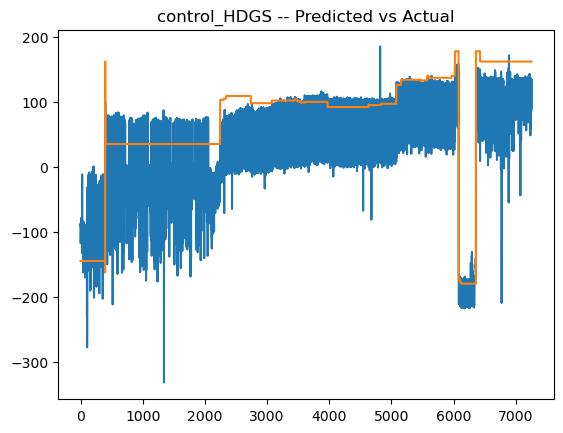

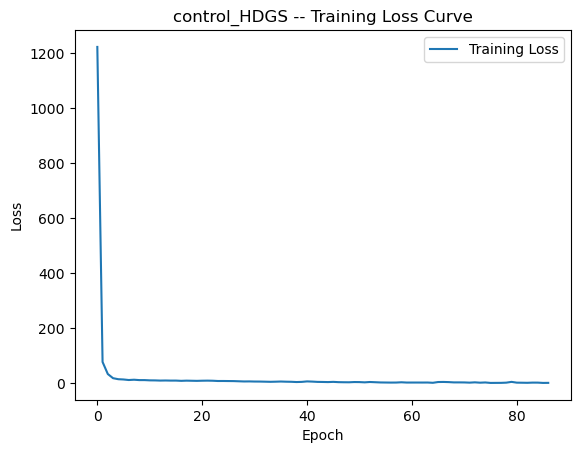

===== Checking control: RUDP =====
train complete
test complete
evaluate complete
模型性能： -191.35930086720174


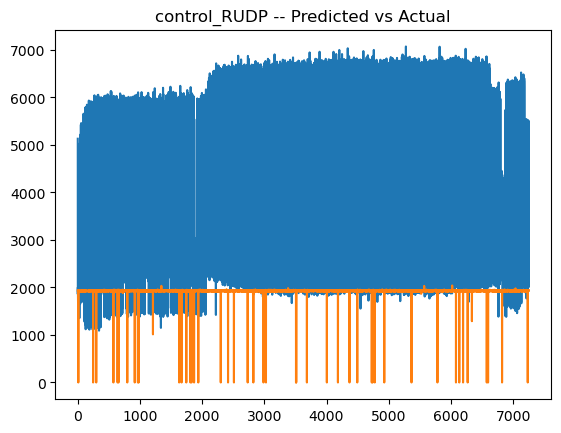

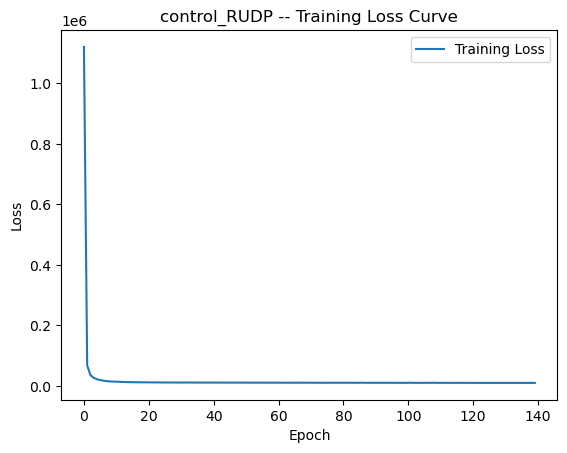

===== Checking control: CCPC =====
train complete
test complete
evaluate complete
模型性能： -371.10439962284


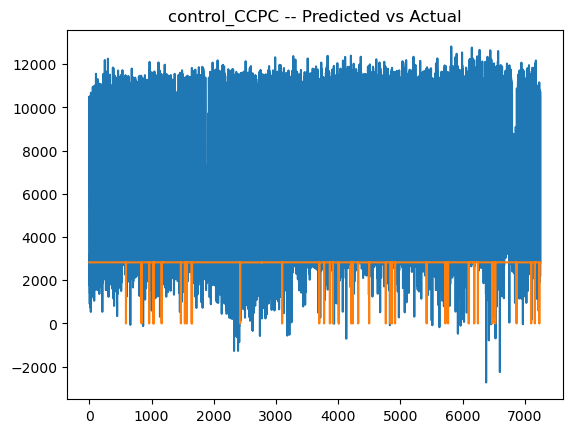

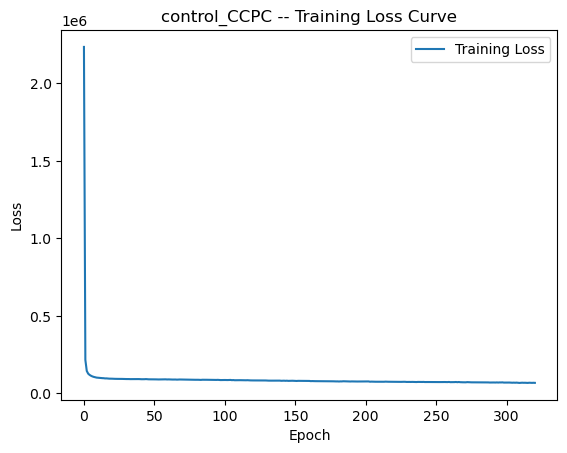

===== Checking control: CCPF =====
train complete
test complete
evaluate complete
模型性能： -41.44411114703984


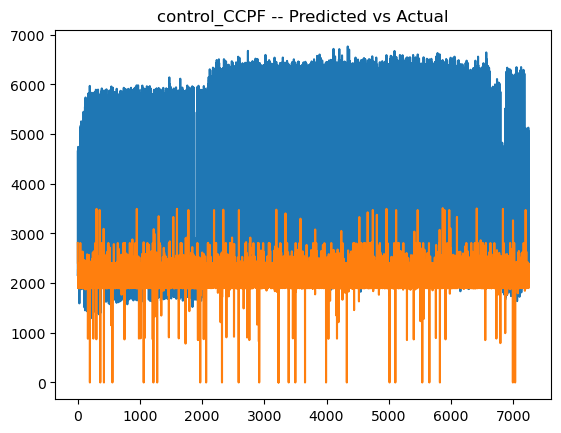

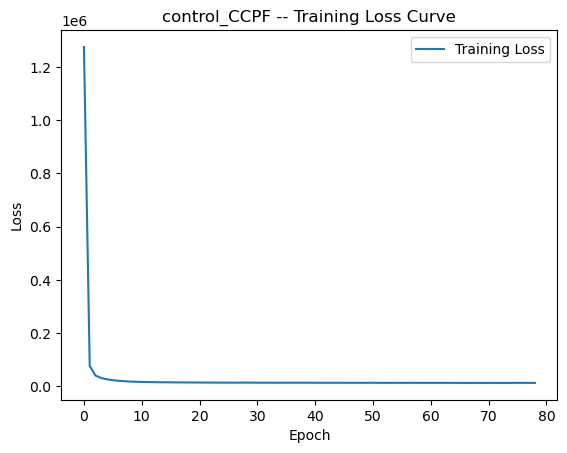

===== Checking control: CWPC =====
train complete
test complete
evaluate complete
模型性能： -211.57325361596602


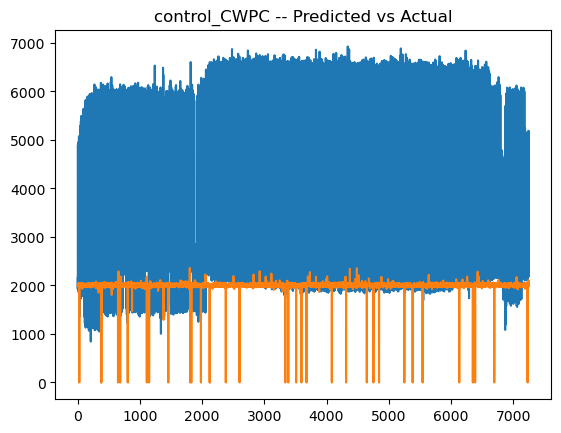

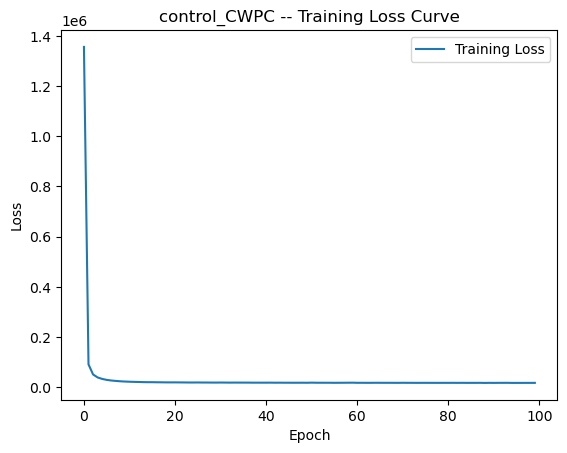

===== Checking control: CWPF =====
train complete
test complete
evaluate complete
模型性能： -113.6026659382472


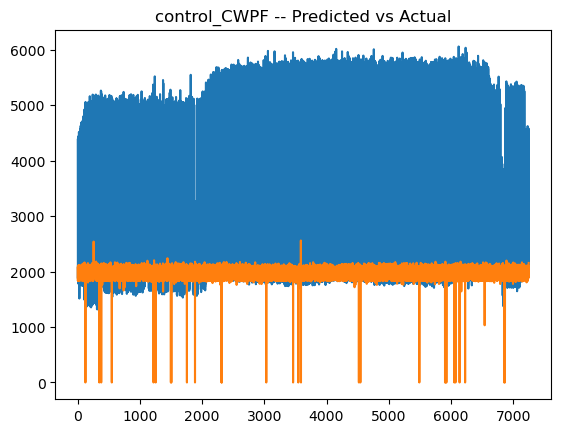

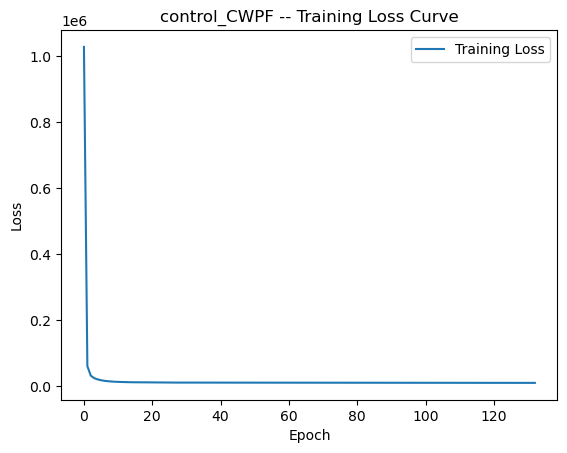

===== Checking control: SNAP =====
train complete
test complete
evaluate complete
模型性能： 0.0


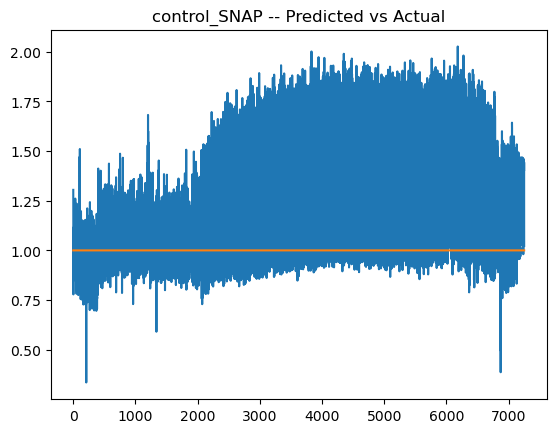

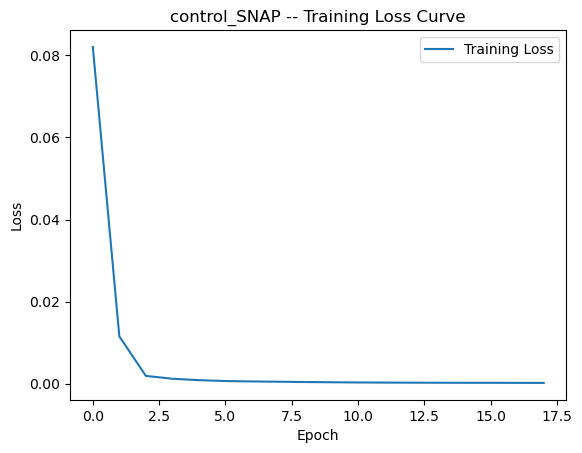

===== Checking control: SHKR =====
train complete
test complete
evaluate complete
模型性能： -2.721460256479199


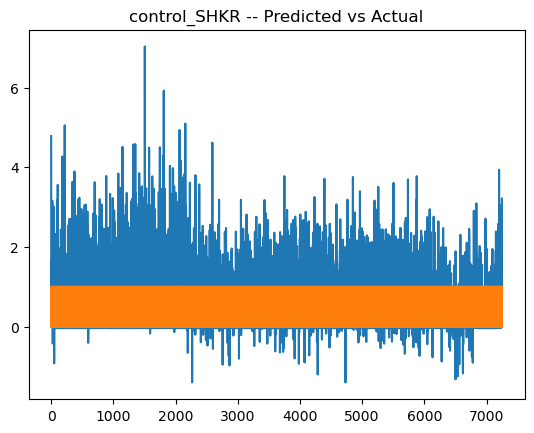

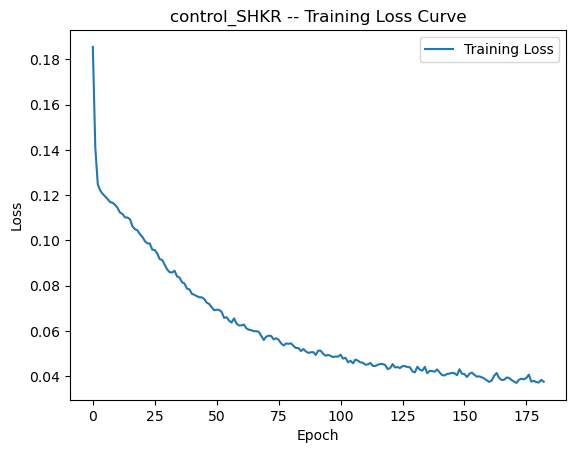

===== Checking control: FADF =====
train complete
test complete
evaluate complete
模型性能： 0.0


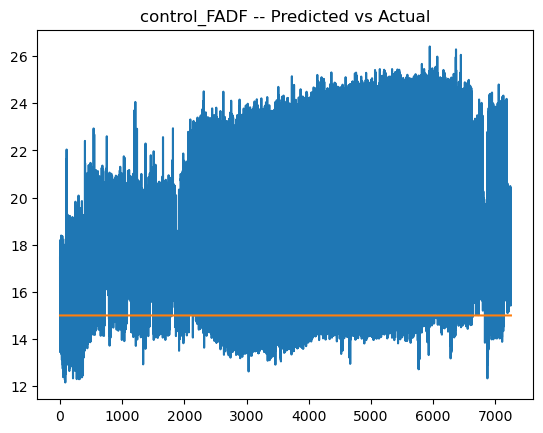

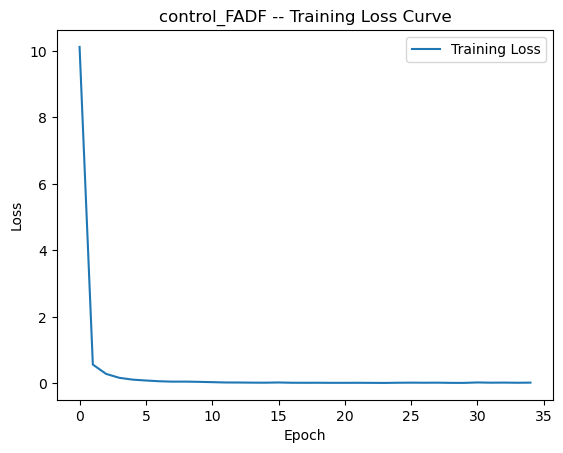

===== Checking external: ALT =====
train complete
test complete
evaluate complete
模型性能： -58.190385082176974


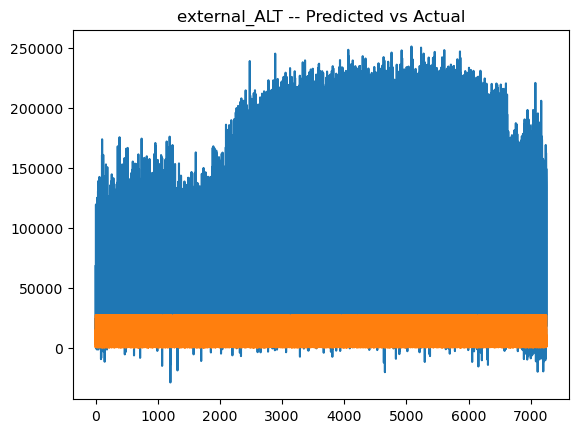

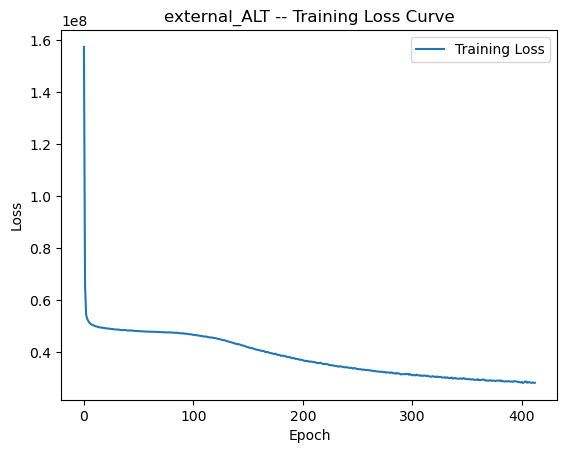

===== Checking external: WS =====
train complete
test complete
evaluate complete
模型性能： -3.952769946666316


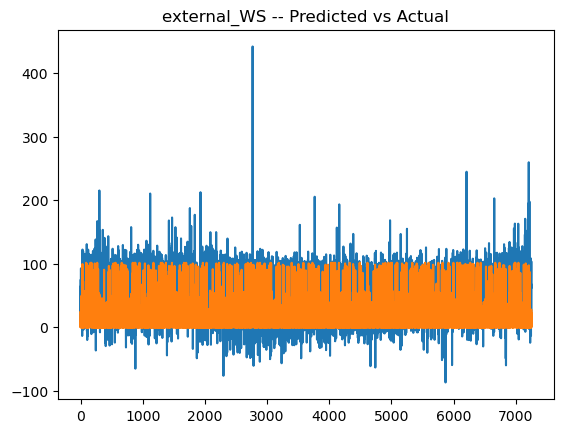

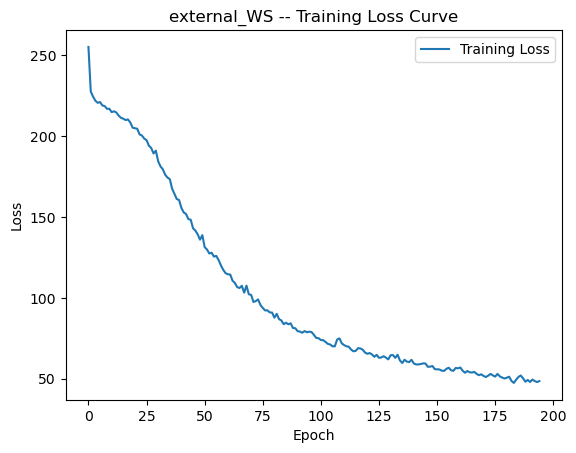

===== Checking external: WD =====
train complete
test complete
evaluate complete
模型性能： -2.7989129253751095


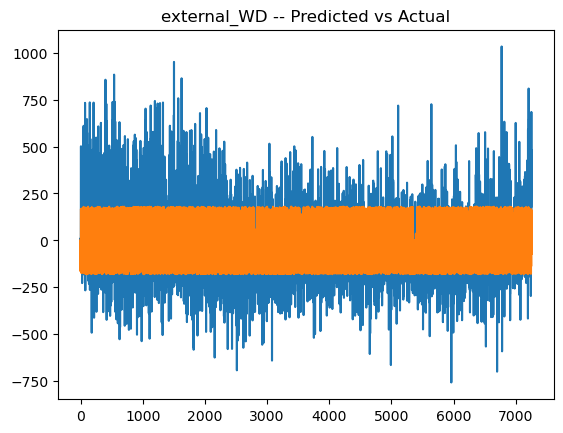

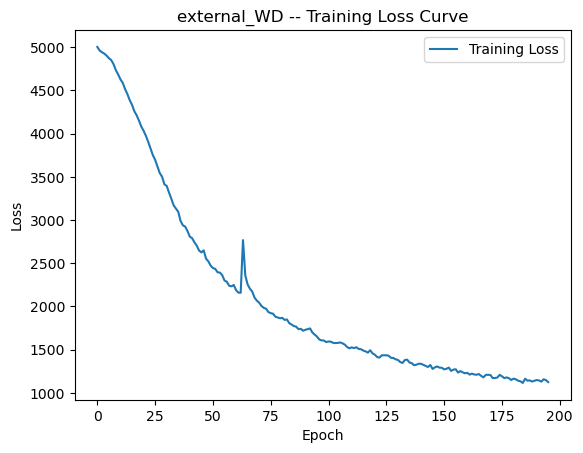

===== Checking external: PT =====
train complete
test complete
evaluate complete
模型性能： -14.079173704707614


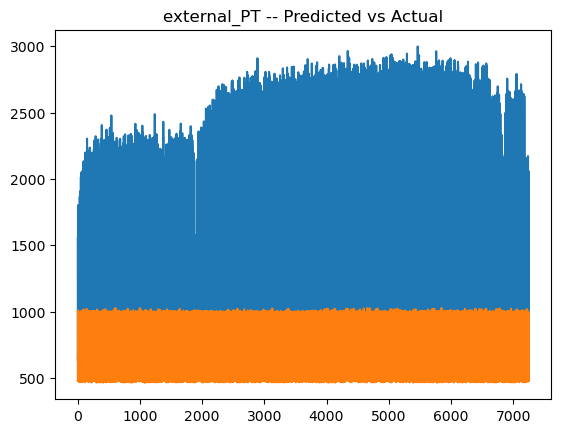

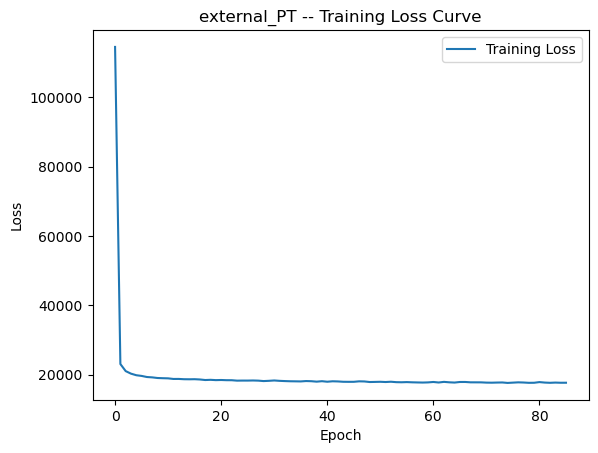

===== Checking external: TAT =====
train complete
test complete
evaluate complete
模型性能： 0.9117626058521276


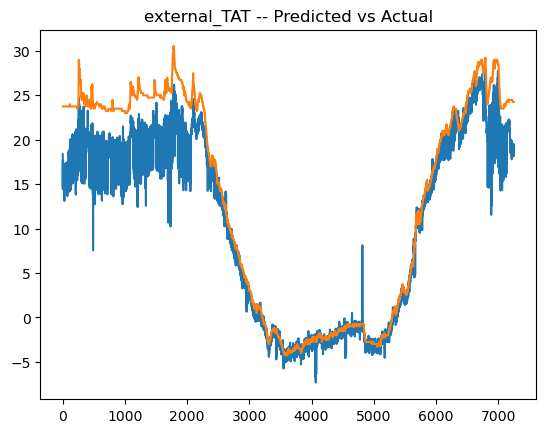

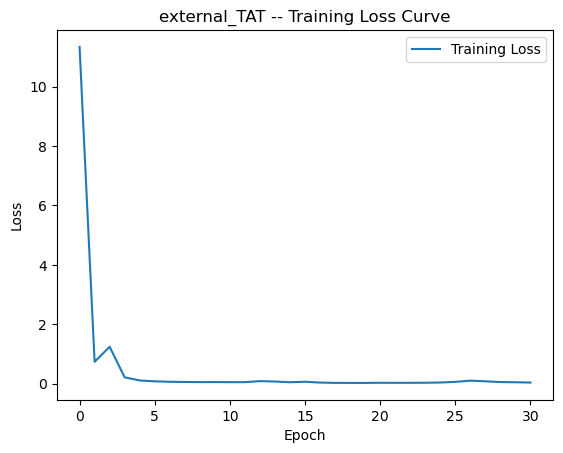

===== Checking external: LOC =====
train complete
test complete
evaluate complete
模型性能： 0.5617538075895441


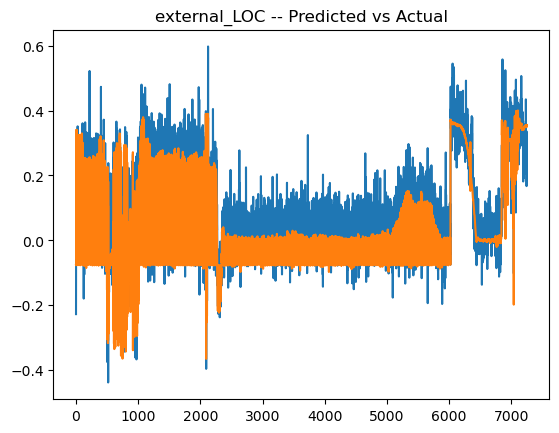

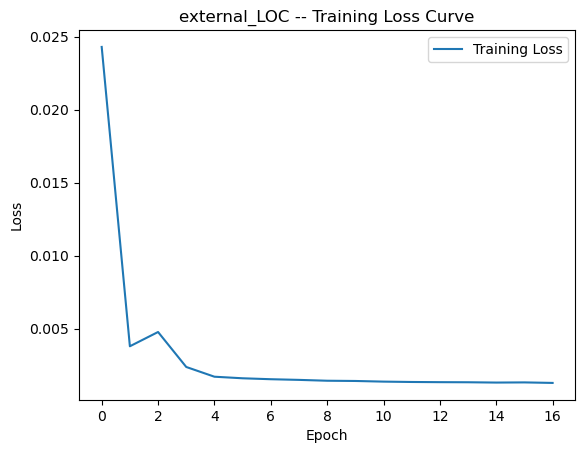

===== Checking recorder: PH =====
train complete
test complete
evaluate complete
模型性能： 0.5609907423010181


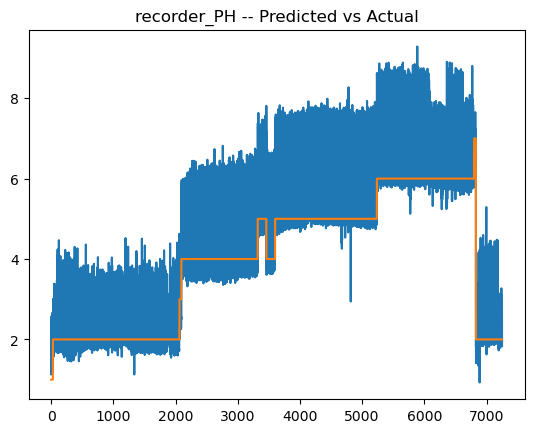

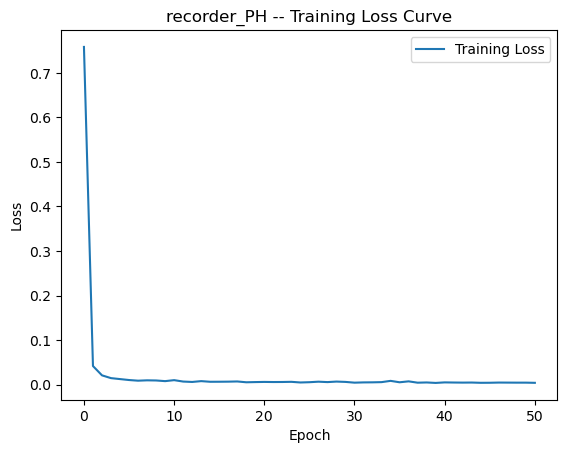

===== Checking unclassified: EVNT =====
train complete
test complete
evaluate complete
模型性能： -1.3818244198699814


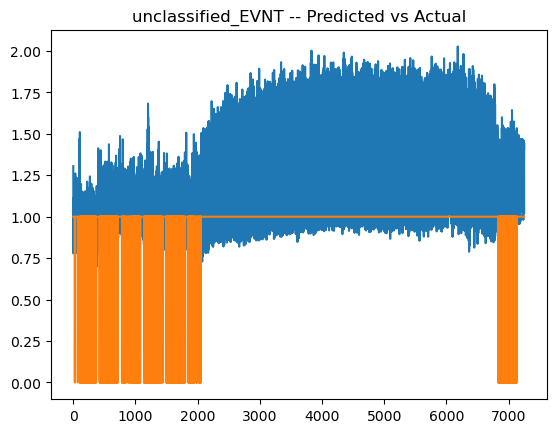

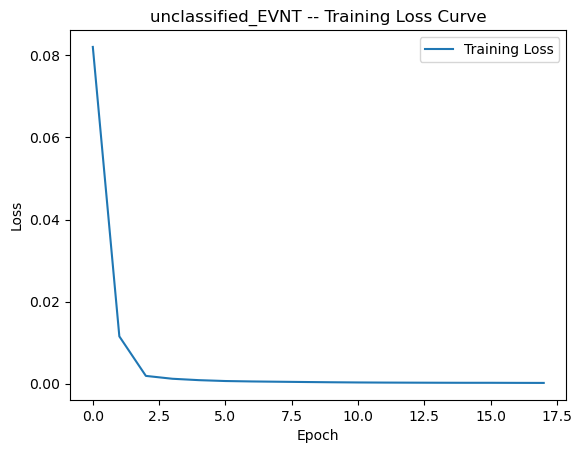

===== Checking unclassified: HF1 =====
train complete
test complete
evaluate complete
模型性能： 0.0


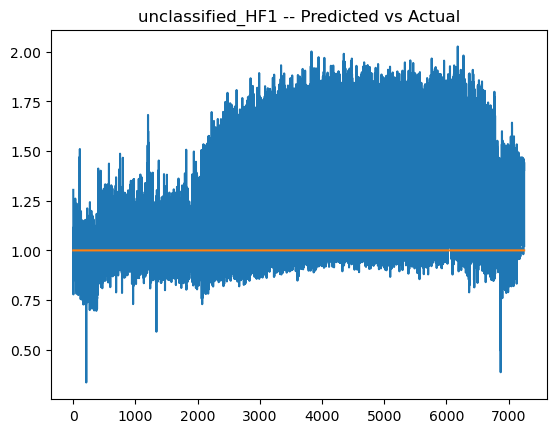

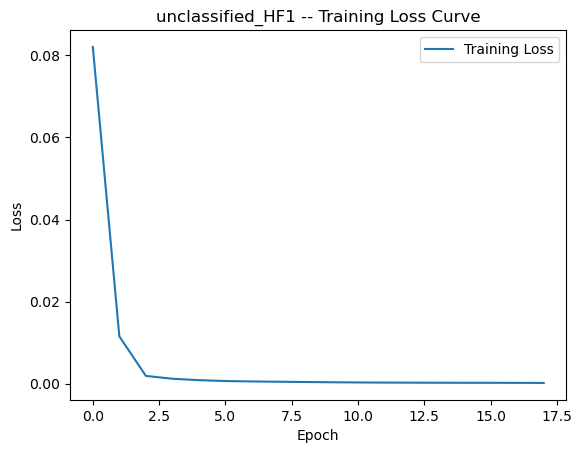

===== Checking unclassified: HF2 =====
train complete
test complete
evaluate complete
模型性能： 0.0


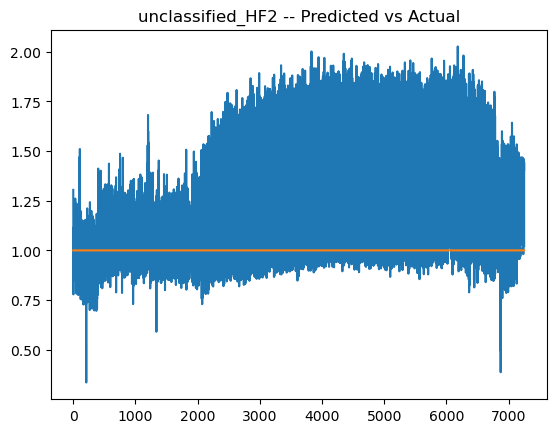

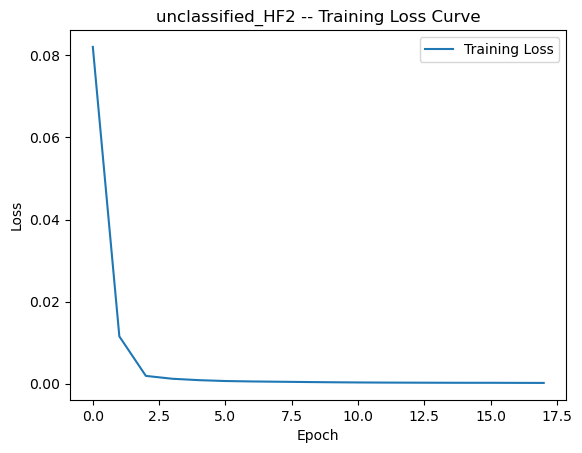

===== Checking unclassified: VHF1 =====
train complete
test complete
evaluate complete
模型性能： -0.8160755162147157


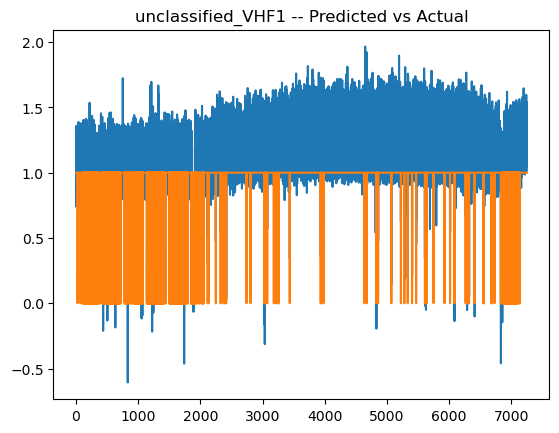

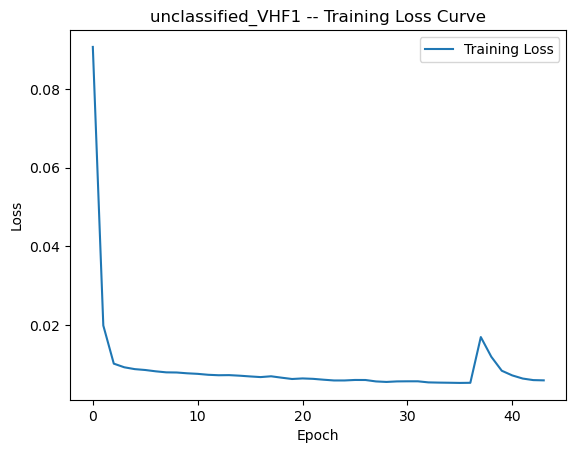

===== Checking unclassified: VHF2 =====
train complete
test complete
evaluate complete
模型性能： -1.3546855950381524


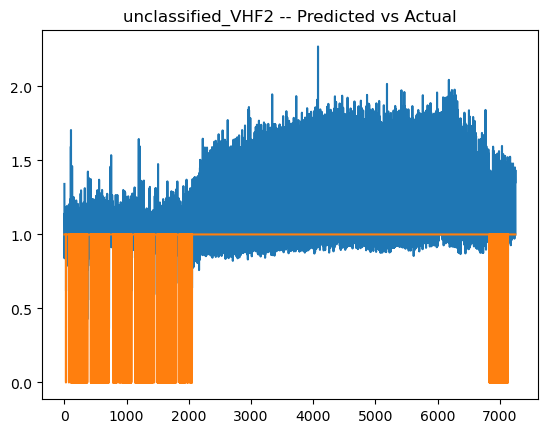

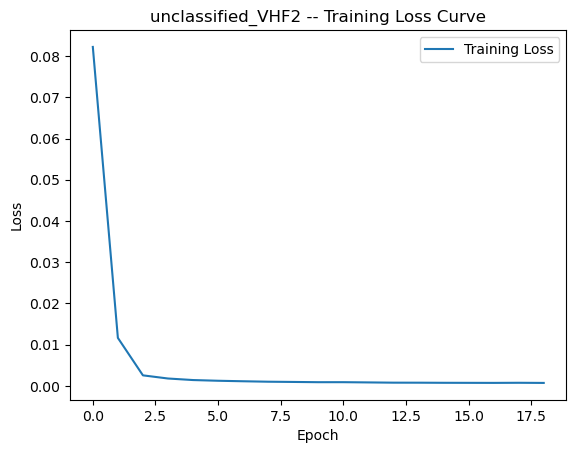

===== Checking unclassified: VHF3 =====
train complete
test complete
evaluate complete
模型性能： -31.262847242684693


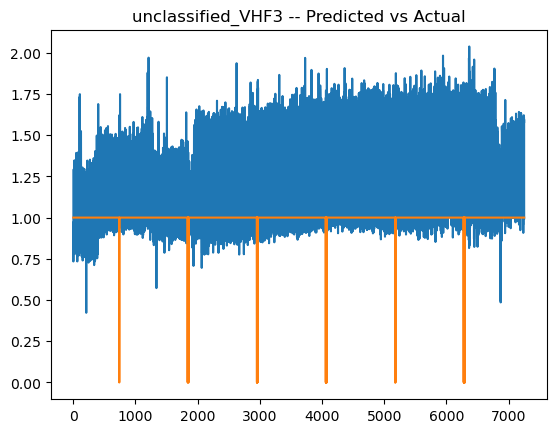

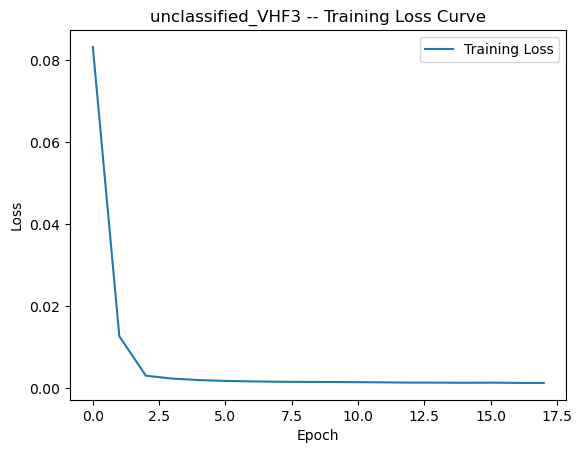

===== Checking unclassified: SMKB =====
train complete
test complete
evaluate complete
模型性能： 0.0


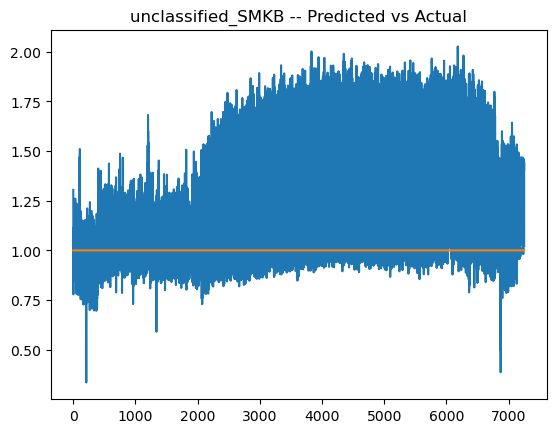

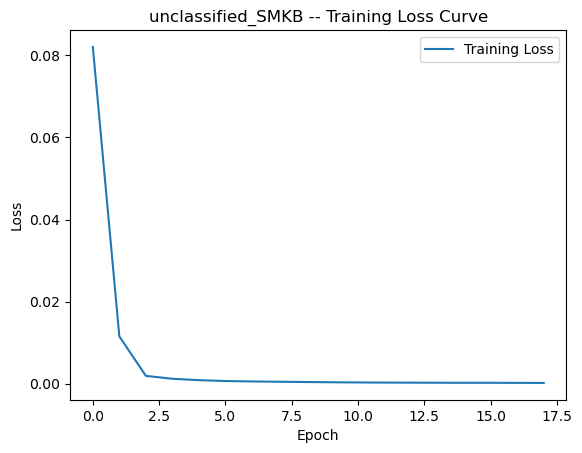

In [23]:
# 构建MLP
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 给定数据存储路径
mlp_save_path = '../result/variable_evaluate/mlp'
if not os.path.exists(mlp_save_path):
    os.mkdir(mlp_save_path)
accuracy_save_path = os.path.join(mlp_save_path, 'accuracy')
loss_save_path = os.path.join(mlp_save_path, 'loss')
if not os.path.exists(accuracy_save_path):
    os.mkdir(accuracy_save_path)
if not os.path.exists(loss_save_path):
    os.mkdir(loss_save_path)

# 初始化数据存储字典
accuracy_dict = {}

# 特征标准化处理
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# 创建MLP回归器实例
mlp = MLPRegressor(hidden_layer_sizes = (100, 50), activation='relu', solver='adam', random_state = 42, max_iter=500, learning_rate='invscaling', learning_rate_init=0.01, verbose=False)
# mlp_list = []

for i in range(0,train_Y.shape[1]):
    group_name, var_name = find_var_name(i)
    print(f"===== Checking {group_name}: {var_name} =====")

    # # 创建MLP回归器实例
    # mlp = MLPRegressor(hidden_layer_sizes = (100, 50), activation='relu', solver='adam', random_state = 42, max_iter=500, learning_rate='invscaling', learning_rate_init=0.01, verbose=False)
    # mlp_list.append(mlp)

    # 训练模型
    mlp.fit(train_X_scaled, train_Y[:,i])
    loss_values = mlp.loss_curve_
    print("train complete")

    # 测试模型
    y_pred = mlp.predict(test_X_scaled)
    # for i in range(y_pred.shape[1]):
    #     plt.figure()
    #     plt.plot(y_pred[:,i], label='Predicted')
    #     plt.plot(test_Y[:,i], label='Actual')
    #     plt.show()
    print("test complete")

    # 评估模型的性能
    accuracy = mlp.score(test_X_scaled, test_Y[:,i])
    accuracy_dict[var_name] = accuracy
    print("evaluate complete")
    if True:
        # 打印模型性能
        print("模型性能：", accuracy)
        plt.figure()
        plt.plot(y_pred, label='Predicted')
        plt.plot(test_Y[:,i], label='Actual')
        plt.title(group_name + '_' + var_name + ' -- Predicted vs Actual')
        plt.savefig(os.path.join(accuracy_save_path, var_name+'_accuracy.png'))
        plt.show()
        # 可视化损失值的变化
        plt.figure()
        plt.plot(loss_values, label='Training Loss')
        plt.title(group_name + '_' + var_name + ' -- Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(loss_save_path, var_name+'_loss.png'))
        plt.show()
    # break

In [24]:
for var_name, accuracy in accuracy_dict.items():
    if accuracy > 0:
        print(var_name, accuracy)

FLAP 0.9949301373353087
FQTY_2 0.9333012523506619
HDGS 0.5665781585107176
TAT 0.9117626058521276
LOC 0.5617538075895441
PH 0.5609907423010181


In [25]:
# 保存模型
import pickle

mlp_save_path = '../result/variable_evaluate/mlp'

# 将模型保存到文件
filename = os.path.join(mlp_save_path, 'mlp_model.pkl')
pickle.dump(mlp, open(filename, 'wb'))
# for i, mlp in enumerate(mlp_list):
#     group_name, var_name = find_var_name(i)
#     filename = os.path.join(mlp_save_path, 'mlp_model_'+var_name+'.pkl')
#     pickle.dump(mlp, open(filename, 'wb'))

# # 加载模型
# loaded_model = pickle.load(open(filename, 'rb'))

# # 使用加载的模型进行预测
# predictions = loaded_model.predict(test_X)